### CONFIGURATION

In [15]:
import pandas as pd
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
import numpy as np
import copy
import sys
import matplotlib.pyplot as plt
%matplotlib inline

In [16]:
# Hartwig imports
sys.path.append("/Users/peterpriestley/hmf/repos/scripts/analysisscripts") 
import analyseVCF as aVCF
import venn as vn

In [17]:
#CHROM SLICING
minChromFrac = 0#17.443476
maxChromFrac = 26#17.491846
#minChromFrac = 17.689695
#maxChromFrac = 17.73896

In [18]:

# COMBINED VCF CONFIG
VCF_SAMPLE = "12878"
VCF_PATH = "/Users/peterpriestley/hmf/analyses/NA12878vsNA12878/"
VCF_FILE_NAME = VCF_SAMPLE + "R_"+ VCF_SAMPLE + "T_merged_somatics.vcf"
SAMPLE_NAMES = {VCF_SAMPLE + 'T.mutect':'mutect', \
                VCF_SAMPLE + 'T.freebayes':'freebayes', \
                'TUMOR.strelka':'strelka', \
                'TUMOR.varscan':'varscan'}
# TRUTH SET
VCF_SAMPLE_TRUTH = VCF_SAMPLE
SAMPLE_NAMES_TRUTH = SAMPLE_NAMES
VCF_PATH_TRUTH = "/Users/peterpriestley/hmf/analyses/lowQualReruns160811/"
VCF_FILE_NAME_TRUTH = VCF_SAMPLE + "R_"+ VCF_SAMPLE + "T_merged_somaticsRERUN.vcf"


### Functions

In [19]:
def filterByChromFrac(df):
    return df[(df.chromFrac > minChromFrac)&(df.chromFrac < maxChromFrac)]

In [20]:
def calculateTruth(df,dfTruth):
    df = pd.merge(df,dfTruth,how='left', left_index=True,right_index=True,suffixes=('', '_Truth'))
    df['Truth'] = ~pd.isnull(df['chromPos_Truth'])
    return df

In [21]:
def calcuatePrecisionSensivityMatrix(df,dfTruth):
    outputdata = []
    for columnName in list(df):
        if columnName.endswith('allele') & ~columnName.endswith('_allele'):
            myCaller = columnName[:-6]
            variantTypes = df[(df[myCaller+'allele'] != '')].variantType.unique()
            for variantType in variantTypes:
                truePositives = len(df[(df[myCaller+'allele'] != '') & (df['Truth'] == True) &(df['variantType'] == variantType)])
                positives = len(df[(df[myCaller+'allele'] != '')&(df['variantType'] == variantType)])
                truthSet = len(dfTruth[(dfTruth['variantType'] == variantType) & (dfTruth.Truth == True)]) 
                falseNegatives = truthSet - truePositives
                if positives > 0:
                    outputdata.append([variantType, myCaller, truthSet,truePositives,positives-truePositives, falseNegatives, \
                                   round(truePositives/float(positives),4),round(truePositives/float(truthSet),4)])
    
    outputDF = pd.DataFrame(outputdata)
    outputDF.columns = (['variantType','caller','truthSet','truePositives','falsePositives','falseNegatives','precision','sensitivity'])
    return outputDF.sort_values(['variantType','caller'])

<h3> Load VCFs and Prepare DF

In [52]:
# LOAD SAMPLE VCF
dfProd = aVCF.loadVaraintsFromVCF(VCF_PATH,VCF_FILE_NAME,SAMPLE_NAMES,VCF_SAMPLE,True)
dfProd = filterByChromFrac(dfProd)
#dfProd = dfProd.set_index(['chrom','pos'])

reading vcf file: 12878R_12878T_merged_somatics.vcf
reading VCF File line: 100000
Number variants loaded: 98590


<h3> SLICE ANALYSIS

In [67]:
# SLICE SETTINGS
#SLICE_VCF_PATH = "/Users/peterpriestley/hmf/slice" + VCF_SAMPLE + "/"
#SLICE_VCF_FILE_NAME = "somatics.merged.vcf"
#SLICE_SAMPLE_NAMES = SAMPLE_NAMES 

In [68]:
#sliceBed = copy.deepcopy(bed)

In [69]:
#dfSlice = aVCF.loadVaraintsFromVCF(SLICE_VCF_PATH,SLICE_VCF_FILE_NAME,SLICE_SAMPLE_NAMES,VCF_SAMPLE,True,False)#True,sliceBed)
#dfSlice = filterByChromFrac(dfSlice)
#dfSlice = dfSlice.set_index(['chrom','pos'])
#dfSlice = calculateTruth(dfSlice,dfProd)

### PRECISION + SENSITIVITY|

In [53]:
# INTERNAL PRECISION + SENSITIVITY by caller - NEW

############### NEED TO FIX FOR FILTER IN VARSCAN #####################
dfProd['Truth'] = (dfProd['numCallers'] >= 2)
outputDF = calcuatePrecisionSensivityMatrix(dfProd,dfProd)
outputDF

,variantType,caller,truthSet,truePositives,falsePositives,falseNegatives,precision,sensitivity
6,INDEL,freebayes,1083,1069,6206,14,0.1469,0.9871
1,INDEL,strelka,1083,21,1849,1062,0.0112,0.0194
3,INDEL,varscan,1083,1081,2601,2,0.2936,0.9982
5,SNP,freebayes,32604,1887,8174,30717,0.1876,0.0579
4,SNP,mutect,32604,30954,15905,1650,0.6606,0.9494
0,SNP,strelka,32604,30953,25911,1651,0.5443,0.9494
2,SNP,varscan,32604,1884,4257,30720,0.3068,0.0578


In [59]:
dfProd.head(30)

,chrom,pos,chromPos,chromFrac,ref,vennSegment,numCallers,variantType,variantSubType,filter,strelkaallele,strelkaAF,strelkaDP,strelkaQS,strelkaSGT,strelkaindelDiff,strelkaindelPos,varscanallele,varscanAF,varscanDP,varscanQS,varscanSGT,varscanindelDiff,varscanindelPos,mutectallele,mutectAF,mutectDP,mutectQS,mutectSGT,mutectindelDiff,mutectindelPos,freebayesallele,freebayesAF,freebayesDP,freebayesQS,freebayesSGT,freebayesindelDiff,freebayesindelPos,patientName,Truth
0,1,27969,1:27969,1.000112,C,freebayes,1,SNP,,.,,,,,,,,,,,,,,,,,,,,,,T,1,6,68.78,unknown,,-1,12878,False
1,1,49243,1:49243,1.000198,G,freebayes,1,SNP,,.,,,,,,,,,,,,,,,,,,,,,,A,1,7,83.99,unknown,,-1,12878,False
2,1,63516,1:63516,1.000255,A,freebayes,1,SNP,,.,,,,,,,,,,,,,,,,,,,,,,G,0.35,20,47.44,unknown,,-1,12878,False
3,1,66372,1:66372,1.000266,TATAT,freebayes,1,INDEL,INSERT,.,,,,,,,,,,,,,,,,,,,,,,TATAATAT,1,12,204.74,unknown,ATA+,-2,12878,False
4,1,66378,1:66378,1.000266,A,freebayes,1,SNP,,.,,,,,,,,,,,,,,,,,,,,,,T,0.4,15,16.51,unknown,,-1,12878,False
5,1,71875,1:71875,1.000288,G,freebayes,1,SNP,,.,,,,,,,,,,,,,,,,,,,,,,A,0.666667,6,73.76,unknown,,-1,12878,False
6,1,74790,1:74790,1.000300,C,freebayes,1,SNP,,.,,,,,,,,,,,,,,,,,,,,,,G,0.875,8,35.04,unknown,,-1,12878,False
7,1,76423,1:76423,1.000307,G,freebayes,1,SNP,,.,,,,,,,,,,,,,,,,,,,,,,A,0.230769,13,16.09,unknown,,-1,12878,False
8,1,98378,1:98378,1.000395,T,freebayes,1,SNP,,.,,,,,,,,,,,,,,,,,,,,,,C,0.857143,7,120.75,unknown,,-1,12878,False
9,1,100876,1:100876,1.000405,T,freebayes,1,SNP,,.,,,,,,,,,,,,,,,,,,,,,,C,0.5,8,7.42,unknown,,-1,12878,False


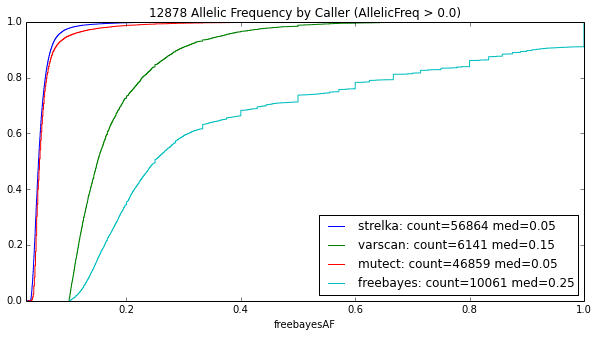

In [57]:
#Alllele Freq By Caller
snpdf = dfProd[(dfProd.variantType == 'SNP')]
for columnName in list(snpdf):
    if columnName.endswith('allele'):
        ser = snpdf[(snpdf[columnName] != '') &(snpdf[columnName[:-6] + 'AF'] > 0.0)][columnName[:-6] + 'AF']
        ser = ser.sort_values()
        #ser[len(ser)] = ser.iloc[-1]
        cum_dist = np.linspace(0.,1.,len(ser))
        ser_cdf = pd.Series(cum_dist, index=ser,name=columnName[:-6]+": count="+str(ser.count())+" med="+str(round(ser.median(),2)))
        ser_cdf.plot(drawstyle='steps',legend=True,title=VCF_SAMPLE+" Allelic Frequency by Caller (AllelicFreq > 0.0)",figsize=[10,5])

In [ ]:
#INTERNAL PRECISION + SENSITIVITY by caller - OLD
#dfTruth['Truth'] = (dfTruth['numCallers'] >= 2)
#outputDF = calcuatePrecisionSensivityMatrix(dfTruth,dfTruth)
#outputDF

In [ ]:
dfProd.head(10)

In [71]:
snpdf = dfProd[(dfProd.variantType == 'SNP')&(dfProd.ref.str.len() ==1)]
pd.pivot_table(snpdf, values='pos', index=['ref'], columns=['mutectallele'], aggfunc='count')

mutectallele,,A,C,G,T
ref,,,,,
A,10141.0,NaN,2378.0,7359.0,1720.0
C,9576.0,2041.0,NaN,1942.0,7926.0
G,9479.0,7874.0,2050.0,NaN,2197.0
T,10198.0,1686.0,7407.0,2279.0,NaN


In [ ]:
#dfTruth[(dfTruth['freebayesallele'] != '') & (dfTruth.variantType == 'SNP')]

In [ ]:
#pd.options.display.max_rows = 200
#caller = "freebayes"
#dfTruth[(dfTruth[caller+'allele'] != '') & (dfTruth.variantType == 'SNP')][['ref',caller+'indelDiff',caller+'QS',caller+'AF','numCallers']]

In [ ]:
#pd.options.display.max_rows = 15000
#caller = "varscan"
#dfProd[(True) &(dfProd[caller+'allele'] != '') & (dfProd.variantType == 'INDEL')][['Truth','ref',caller+'indelDiff',caller+'QS',caller+'AF','numCallers']]

## False Positive Analysis

In [ ]:
unfilteredBed = copy.deepcopy(bed)

In [ ]:
# SETTINGS
myCaller = 'varscan'
UNFILTERED_VCF_PATH = "/Users/peterpriestley/hmf/70-30slice/"
if myCaller == 'varscan':
    UNFILTERED_VCF_FILE_NAME = "varscan.snp.vcf"
    UNFILTERED_SAMPLE_NAMES = {"TUMOR":myCaller}
elif myCaller == 'freebayes':
    UNFILTERED_VCF_FILE_NAME = "freebayes.somatic.vcf"
    UNFILTERED_SAMPLE_NAMES = {'CPCT11111111T':myCaller}  
elif myCaller == 'strelka':
    UNFILTERED_VCF_FILE_NAME = "/strelka/results/all.somatic.snvs.vcf"
    UNFILTERED_SAMPLE_NAMES = {"TUMOR":myCaller}
elif myCaller == 'mutect':
    UNFILTERED_VCF_FILE_NAME = "mutect.vcf"
    UNFILTERED_SAMPLE_NAMES = {'CPCT11111111T':myCaller}


dfUnfiltered = aVCF.loadVaraintsFromVCF(UNFILTERED_VCF_PATH,UNFILTERED_VCF_FILE_NAME,UNFILTERED_SAMPLE_NAMES,VCF_SAMPLE,False,True,unfilteredBed)
dfUnfiltered['Truth']=dfUnfiltered.chromPos.isin(dfTruth['chromPos']) 
dfUnfiltered = dfUnfiltered[(dfUnfiltered.chromFrac > minChromFrac)&(dfUnfiltered.chromFrac < maxChromFrac)]

In [ ]:
dfTruth['inUnfiltered'+myCaller]=dfTruth.chromPos.isin(dfUnfiltered[dfUnfiltered[myCaller+'allele'] != '']['chromPos'])
dfTruth['inSlice']=dfTruth.chromPos.isin(dfSlice['chromPos'])

In [ ]:
#False Positives - pre-somatic
dfTruth[['inSlice','pos','inUnfiltered'+myCaller,'variantType']].groupby(['variantType','inUnfiltered'+myCaller]).agg('count')


In [ ]:
dfUnfiltered['inSlice'+myCaller]=dfUnfiltered.chromPos.isin(dfSlice[dfSlice[myCaller+'allele'] != '']['chromPos'])
dfUnfiltered['inSlice']=dfUnfiltered.chromPos.isin(dfSlice['chromPos'])

In [ ]:
dfUnfiltered[['inSlice'+myCaller,'pos','Truth','variantType','filter']].groupby(['variantType','inSlice'+myCaller,'Truth','filter']).agg('count')


In [ ]:

dfUnfiltered[(dfUnfiltered['Truth'] == True)&
            (dfUnfiltered['inSlice'+myCaller] == True)& 
             (dfUnfiltered.variantType == 'SNP') &
             (dfUnfiltered['filter'] != 'PETE')]['pos']

In [ ]:
#FALSE NEGATIVES IN UNFILTERED
dfUnfiltered[(dfUnfiltered['inSlice'+myCaller] == False)& 
             (dfUnfiltered[myCaller+'somaticGT'] != '2')&
             (dfUnfiltered.variantType == 'SNP') &
             (dfUnfiltered['filter'] != 'str10')].sort_values([myCaller+'QS'],ascending=False)

In [ ]:
dfSlice[dfSlice.pos>'37577400'].head(10)

In [ ]:
#FALSE POSITIVES`
dfUnfiltered[(dfUnfiltered['inSlice'+myCaller] == True) & (dfUnfiltered.variantType == 'SNP') &
             (dfUnfiltered['Truth'] == False)].sort_values([myCaller+'QS'],ascending=False)

<h3> SNP

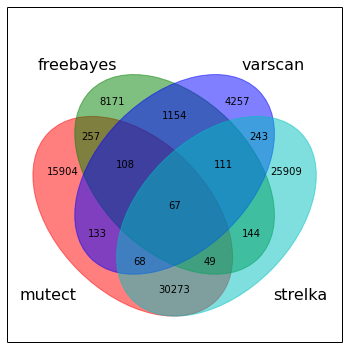

In [26]:
snpdf = dfProd[(dfProd.variantType == 'SNP')]
vn.venn([snpdf[snpdf.mutectallele != '']['chromPos'], \
         snpdf[snpdf.strelkaallele != '']['chromPos'], \
        snpdf[snpdf.freebayesallele != '']['chromPos'], \
        snpdf[snpdf.varscanallele != '']['chromPos'] \
        ],['mutect','strelka','freebayes','varscan'],figsize=(6,6))

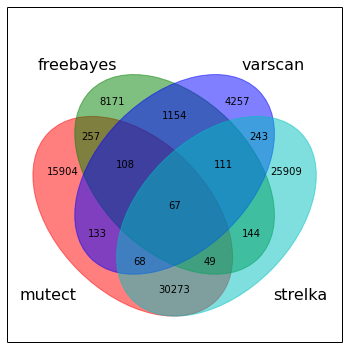

In [28]:
snpdf = dfProd[(dfTruth.variantType == 'SNP')]
vn.venn([snpdf[snpdf.mutectallele != '']['chromPos'], \
         snpdf[snpdf.strelkaallele != '']['chromPos'], \
        snpdf[snpdf.freebayesallele != '']['chromPos'], \
        snpdf[snpdf.varscanallele != '']['chromPos'] \
        ],['mutect','strelka','freebayes','varscan'],figsize=(6,6))

### <hd3> Indel Venn

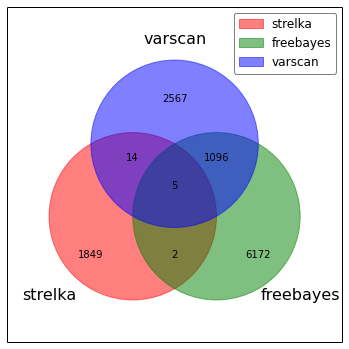

In [29]:
indeldf= dfProd[(dfProd.variantType == 'INDEL')]
vn.venn([indeldf[indeldf.strelkaallele != '']['chromPos'], \
        indeldf[indeldf.freebayesallele != '']['chromPos'], \
        indeldf[indeldf.varscanallele != '']['chromPos'] \
        ],['strelka','freebayes','varscan'],figsize=(6,6))

In [ ]:
indeldf= dfTruth[(dfTruth.variantType == 'INDEL')]
vn.venn([indeldf[indeldf.strelkaallele != '']['chromPos'], \
        indeldf[indeldf.freebayesallele != '']['chromPos'], \
        indeldf[indeldf.varscanallele != '']['chromPos'] \
        ],['strelka','freebayes','varscan'],figsize=(6,6))

### <hd3> Read Depth

In [ ]:
for columnName in list(df):
    if columnName.endswith('allelicFreq'):
        df[df[columnName] != ''].hist(column=columnName,by="Truth",bins=40,figsize=(10,5))
        

In [ ]:
df[df.freebayesreadDepth != ''].hist(column="freebayesallelicFreq",by="Truth",bins=30)

## Qual Score

In [ ]:
# INDELS BY CALLER BY TRUTH
caller = 'strelka'
truths = indeldf.Truth.unique()
for truth in truths:
    ser = indeldf[(indeldf.Truth == truth) &(indeldf[caller+'allele'] != '')][caller + 'QS']
    ser = ser.sort_values()
    cum_dist = np.linspace(0.,1.,len(ser))
    ser_cdf = pd.Series(cum_dist, index=ser,name=caller+" INDEL "+str(truth)+": c="+str(ser.count())+" m="+str(round(ser.median(),2)))
    ser_cdf.plot(drawstyle='steps',legend=True,title=caller+" Qual Score CDF - INDELS",figsize=[15,6], xlim=[0,100],ylim=[0,1])

truths = snpdf.Truth.unique()
for truth in truths:
    ser = snpdf[(snpdf.Truth == truth) &(snpdf[caller+'allele'] != '')][caller + 'QS']
    ser = ser.sort_values()
    cum_dist = np.linspace(0.,1.,len(ser))
    ser_cdf = pd.Series(cum_dist, index=ser,name=caller+" SNP "+str(truth)+": c="+str(ser.count())+" m="+str(round(ser.median(),2)))
    ser_cdf.plot(drawstyle='steps',legend=True,title=caller+"Qual Score CDF",figsize=[15,6],xlim=[0,100],ylim=[0,1])

<h3> Allelic Depth

In [ ]:
#Alllele Freq By Caller
for columnName in list(snpdf):
    if columnName.endswith('allele'):
        ser = snpdf[(snpdf[columnName] != '') &(snpdf[columnName[:-6] + 'AF'] > 0.0)][columnName[:-6] + 'AF']
        ser = ser.sort_values()
        #ser[len(ser)] = ser.iloc[-1]
        cum_dist = np.linspace(0.,1.,len(ser))
        ser_cdf = pd.Series(cum_dist, index=ser,name=columnName[:-6]+": count="+str(ser.count())+" med="+str(round(ser.median(),2)))
        ser_cdf.plot(drawstyle='steps',legend=True,title=VCF_SAMPLE+" Allelic Frequency by Caller (AllelicFreq > 0.0)",figsize=[10,5])

In [ ]:
#Alllele Freq By Caller
for columnName in list(snpdf):
    if columnName.endswith('allele'):
        ser = snpdf[(snpdf[columnName] != '') &(snpdf[columnName[:-6] + 'AF'] > 0.0)][columnName[:-6] + 'AF']
        ser = ser.sort_values()
        #ser[len(ser)] = ser.iloc[-1]
        cum_dist = np.linspace(0.,1.,len(ser))
        ser_cdf = pd.Series(cum_dist, index=ser,name=columnName[:-6]+": c="+str(ser.count())+" m="+str(round(ser.median(),2)))
        ser_cdf.plot(drawstyle='steps',legend=True,title=" Allelic Frequency by Caller (AllelicFreq > 0.0)",figsize=[15,6])

In [ ]:
# BY CALLER BY TRUTH
truths = snpdf.Truth.unique()
for truth in truths:
    for columnName in list(snpdf):
        if columnName.endswith('allele'):
            ser = snpdf[(snpdf.Truth == truth) &(snpdf[columnName] != '')][columnName[:-6] + 'allelicFreq']
            ser = ser.sort_values()
            #ser[len(ser)] = ser.iloc[-1]
            cum_dist = np.linspace(0.,1.,len(ser))
            ser_cdf = pd.Series(cum_dist, index=ser,name=columnName[:-6]+" "+str(truth)+": c="+str(ser.count())+" m="+str(round(ser.median(),2)))
            ser_cdf.plot(drawstyle='steps',legend=True,title=" Allelic Frequency by Caller and Truth",figsize=[15,6])

In [ ]:
#  BY VENN SEGMENT - Single Caller - FALSE POSITIVES
myCaller = 'freebayes'
vennSegments = snpdf[(snpdf[myCaller+'allele'] != '') & (snpdf.Truth == False)].vennSegment.unique()
for vennSegment in vennSegments:
    ser = snpdf[(snpdf.vennSegment == vennSegment) & (snpdf[myCaller+'allele'] != '') & (snpdf.Truth == False) ][myCaller+'allelicFreq']
    ser = ser.sort_values()
    ser[len(ser)] = ser.iloc[-1]
    cum_dist = np.linspace(0.,1.,len(ser))
    ser_cdf = pd.Series(cum_dist, index=ser,name=vennSegment+": c="+str(ser.count())+" m="+str(round(ser.median(),2)))
    ser_cdf.plot(drawstyle='steps',legend=True,title=myCaller+" FP by Venn Segment",figsize=[15,6])

### Allelic Depth Scatter Plot

In [ ]:
caller1 = 'varscan'
caller2 = 'strelka'
tempdf = df[(df[caller1+'allele']!='')&(df[caller2+'allele']!='')]
tempdf.head()
tempdf.plot.scatter(caller1+'allelicFreq',caller2+'allelicFreq' \
                        ,figsize=[6,6] \
                        ,title="Comparison of "+caller1+" and "+caller2+" Allelic Frequency" \
                        ,xlim=[0,1],ylim=[0,1])

<h3> RAINBOW CHARTS

In [ ]:
## RAINBOW
caller = 'freebayes'
plt.scatter(df[(df[caller+'allele']!='')& (df['Truth'] == True)&(df['chrom'] == '22')]['chromFrac'], \
            df[(df[caller+'allele']!='')& (df['Truth'] == True)&(df['chrom'] == '22')][caller+'allelicFreq'], \
            s=10, c='b', marker="s")

In [ ]:
## RAINBOW
caller = 'freebayes'
plt.scatter(df[(df[caller+'allele']!='')& (df['Truth'] == False)&(df['chrom'] == '22')]['chromFrac'], \
            df[(df[caller+'allele']!='')& (df['Truth'] == False)&(df['chrom'] == '22')][caller+'allelicFreq'], \
            s=10, c='b', marker="s")

<h3> Overlapping Analysis

In [ ]:
#NEEDS REFACTORING TO SUPPORT NEW DF FORMAT
'''
sorteddf = df.sort(['chromFrac'], ascending=1)
sorteddf['nextRef'] = sorteddf['ref'].shift(-2)
sorteddf['nextPos'] = sorteddf['pos'].shift(-2)
sorteddf['nextChrom'] = sorteddf['chrom'].shift(-2)
sorteddf['nextVT'] = sorteddf['variantType'].shift(-2)
sorteddf['nextAlleleTumor1'] = sorteddf['alleleTumor1'].shift(-2)
sorteddf['nextAlleleTumor2'] = sorteddf['alleleTumor2'].shift(-2)
sorteddf['nextVennSegment'] = sorteddf['vennSegment'].shift(-2)
sorteddf['lengthRef'] = sorteddf['ref'].str.len()
sorteddf['Dist2Next'] = -sorteddf['pos'].astype(int).diff(-2)

overlapdf = sorteddf[(sorteddf['lengthRef']+0>sorteddf['Dist2Next']) & (sorteddf['Dist2Next']>0)]
overlapdf.head(20)
'''

In [ ]:
#NEEDS REFACTORING TO SUPPORT NEW DF FORMAT
'''
filtereddf = overlapdf[(~overlapdf.vennSegment.isin(['freebayes','varscan','strelka1'])) \
                       & (overlapdf.vennSegment.str.contains('varscan')) \
                       #& (~overlapdf.nextVennSegment.str.contains('varscan')) \
                       & (overlapdf.variantType == 'INDEL') \
                       #& (overlapdf.variantSubType == 'DELETE')
                       & (overlapdf.variantType == overlapdf.nextVT)]
filtereddf[['nextVennSegment','vennSegment','variantType','nextVT','Dist2Next','lengthRef','ref','alleleTumor2', \
            'nextRef','nextAlleleTumor2','variantSubType','chrom','pos']].count()
'''